In [1]:
import numpy as np
import corner
import emcee

import matplotlib.pyplot as plt

In [2]:
read = emcee.backends.HDFBackend("Autolens_eNFW.h5")

In [3]:
#Get all chains of Emcee.
#Frist input is the iteration, and second the walker number, e.g., 
#chain[10][13] get the walker number 13 in the 10 iteration.
chain = read.get_chain()   

In [4]:
#Get all log_probabilities
#Frist input is the iteration, and second the walker number, e.g., 
#chain[10][13] get the walker number 13 in the 10 iteration.

log_prob = read.get_log_prob()
best_log = np.where(log_prob == log_prob.max())
print(log_prob.max())

0.0


In [5]:
#parameters of best walker
best_walker = chain[best_log][1]

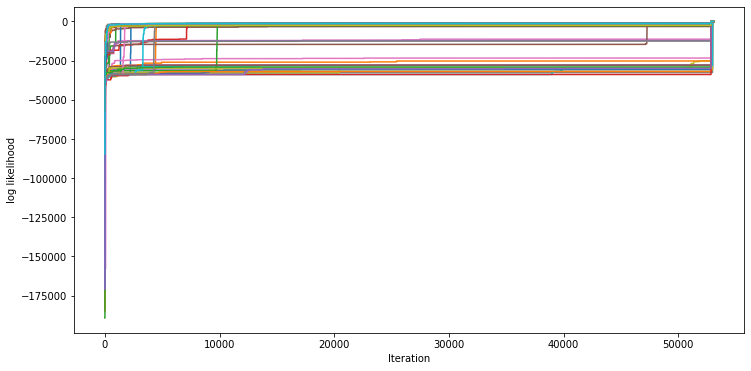

In [7]:
plt.figure(figsize=(12,6))
for i in range(log_prob.shape[1]):
    plt.plot(log_prob[:,i])
    #plt.ylim(100, 500)
    plt.xlim()
    plt.ylabel("log likelihood")
    plt.xlabel("Iteration")

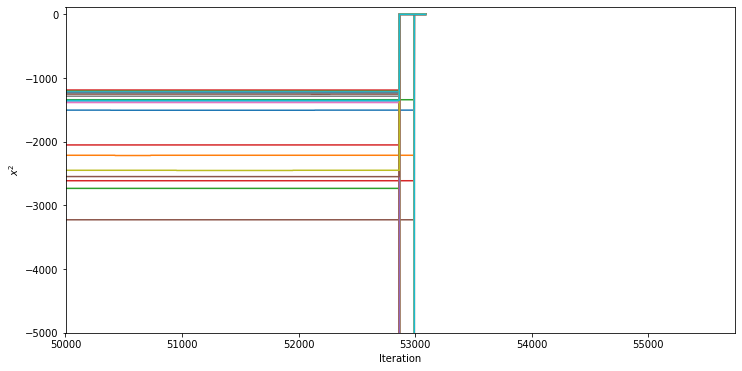

In [18]:
plt.figure(figsize=(12,6))
for i in range(log_prob.shape[1]):
    plt.plot(log_prob[:,i])
    plt.ylim(-5000, 120)
    plt.xlim(50000)
    plt.ylabel("$ x^2 $")
    plt.xlabel("Iteration")

In [19]:
#Get the number of accepted values
#E.g, accepted[10] = 2, means walker 10 was accepted 2 times

accepted = read.accepted
print("Number of accepted walkers:",np.count_nonzero(accepted))
accepted

Number of accepted walkers: 40


array([ 86.,  69., 226.,  87.,  35.,  27.,  27.,  50., 156.,  48., 160.,
       178.,  59., 159., 277.,  69.,  53.,  54.,  44.,  76., 248.,  30.,
        78.,  78.,  40., 230., 169.,  24.,  29., 102., 232.,  69.,  47.,
       122., 174.,  80.,  73., 480.,  68., 620.])

[ 976.03383722  876.31618394 1013.42807656  885.619376   1015.09744985]
flat chain shape: (788840, 5)
flat log prob shape: (788840,)


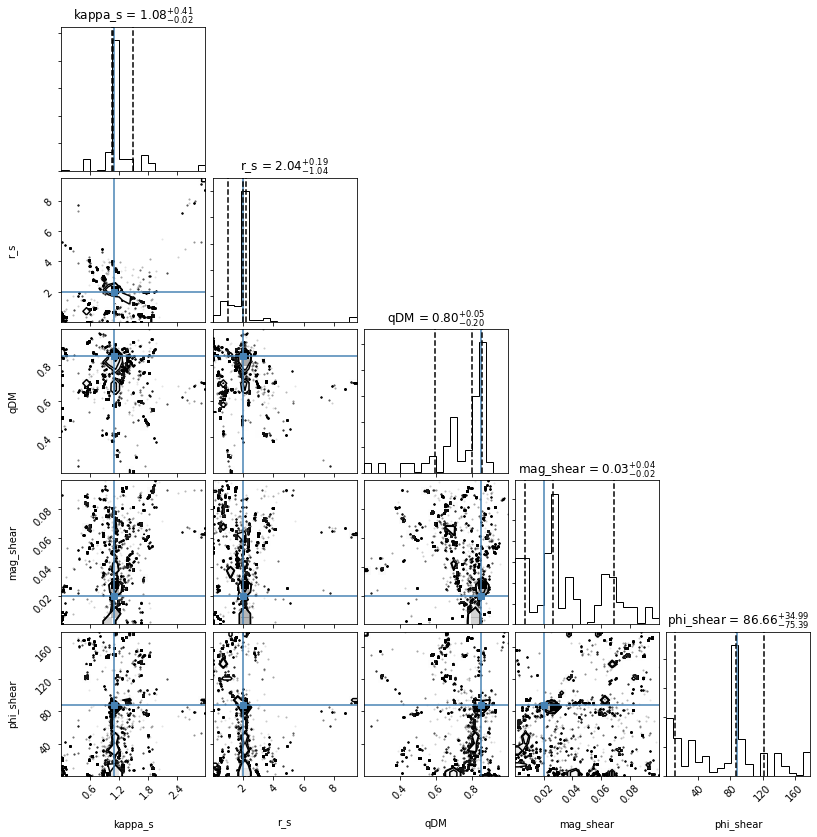

In [9]:
#Corner plots

labels = ["kappa_s", "r_s", "qDM", "mag_shear", "phi_shear"]
truth = [1.1, 2.0, 0.85, 0.02, 88]

tau = read.get_autocorr_time(tol=0)
print(tau)
samples = read.get_chain(flat=True)
log_prob_samples = read.get_log_prob(flat=True)


print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

labels += ["log prob"]

corner.corner(samples, labels=labels,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=truth);

5994 1498
flat chain shape: (1240, 5)
flat log prob shape: (1240,)


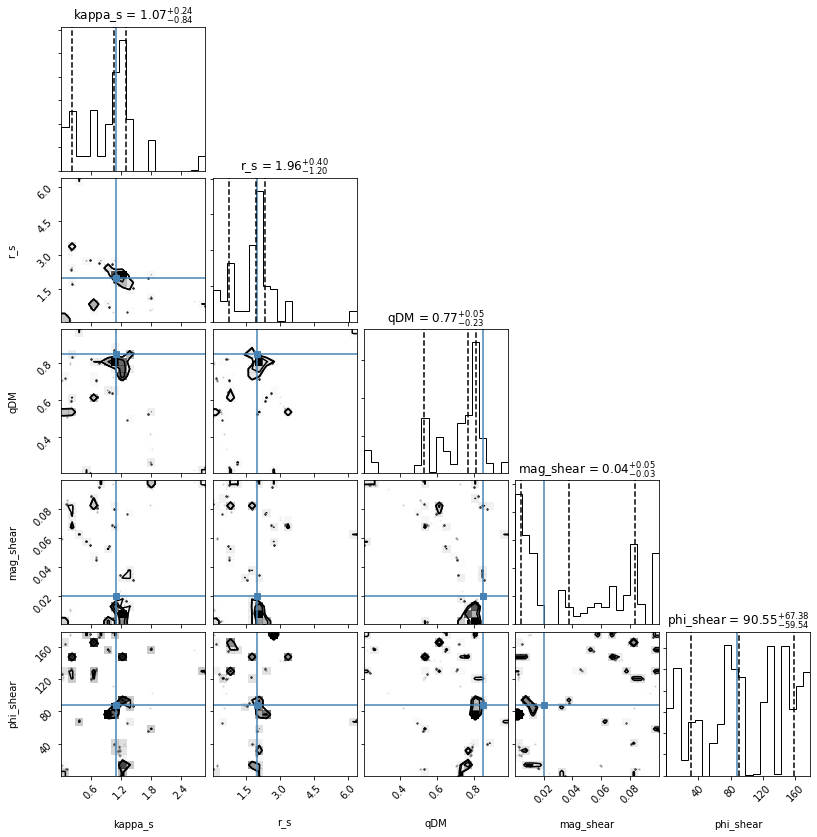

In [20]:
#Corner plots
tau = read.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.max(tau))
print(burnin, thin)
labels = ["kappa_s", "r_s", "qDM", "mag_shear", "phi_shear"]
truth = [1.1, 2.0, 0.85, 0.02, 88]


samples = read.get_chain(discard=burnin, flat=True,thin=thin )
log_prob_samples = read.get_log_prob(discard=burnin,flat=True,thin=thin)


print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

labels += ["log prob"]

corner.corner(samples, labels=labels,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=truth);

In [21]:
from IPython.display import display, Math
best_fit = np.zeros(len(labels)-1)

for i in range(len(labels)-1):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    best_fit[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
tau = read.get_autocorr_time(tol=0)
print(tau, read.iteration/50)

[2347.05819379 2572.31171389 2691.32830756 2890.10201823 2997.25642092] 1061.8


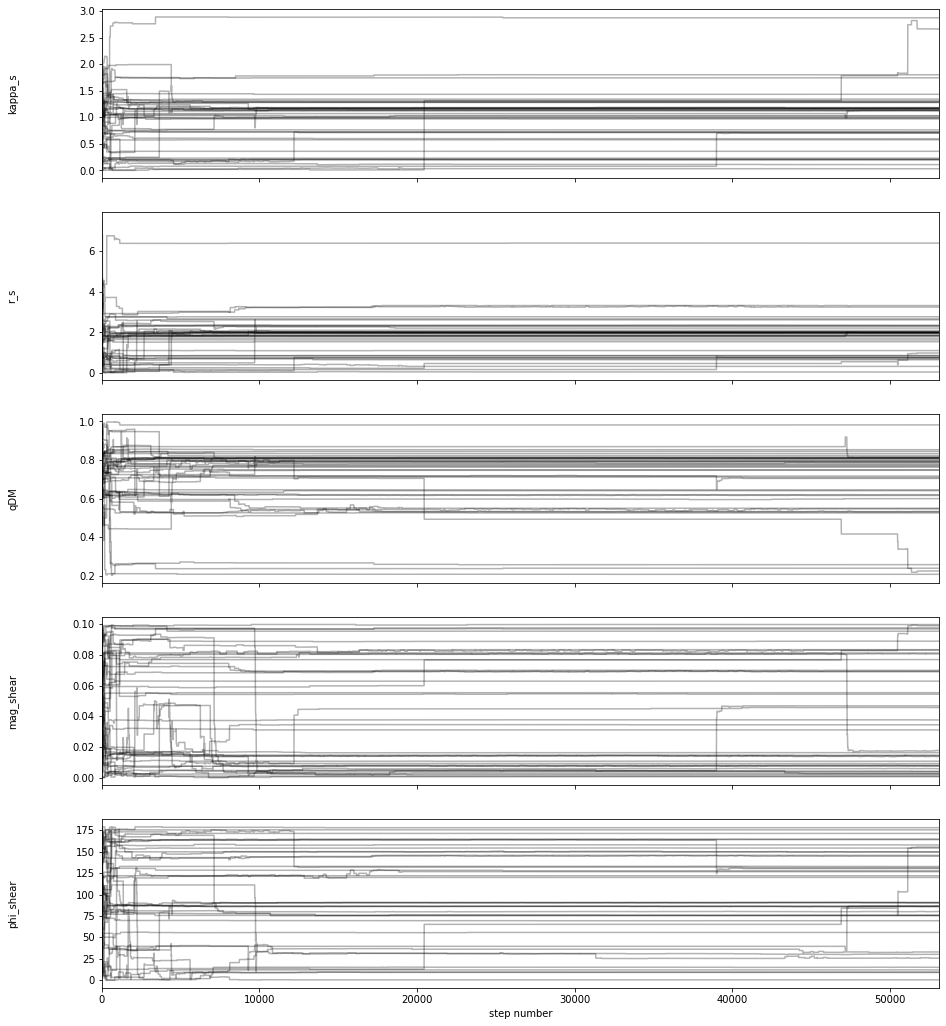

In [23]:
#Walke of each walker
fig, axes = plt.subplots(len(labels)-1, figsize=(15, 18), sharex=True)
samples = read.get_chain()

for i in range(len(labels)-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [24]:
it, accep_tot, time, accep_100 = np.loadtxt("Output_LogFile.txt", unpack=True)

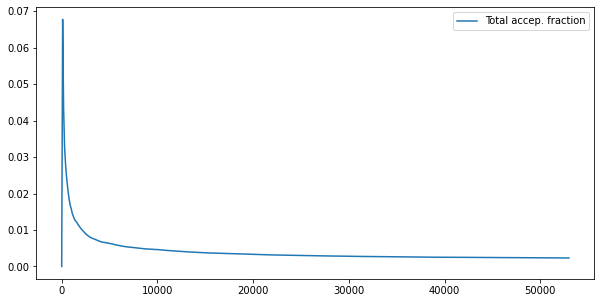

In [25]:
#Plot accep_tot vs it
plt.figure(figsize=(10,5))

plt.plot(it, accep_tot, label="Total accep. fraction")
plt.legend()

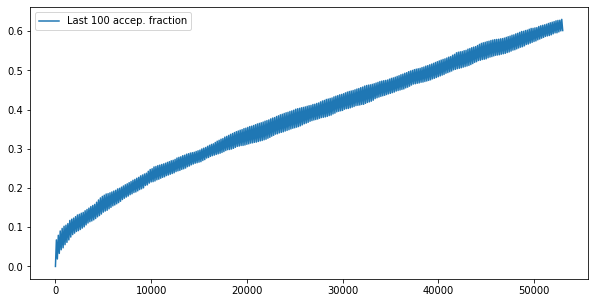

In [26]:
#Plot accep_100 vs it
plt.figure(figsize=(10,5))

plt.plot(it, accep_100, label="Last 100 accep. fraction")
#plt.ylim(0.15,)
plt.legend()

## Plot Model Best-Fit

In [27]:
import os

os.environ["OMP_NUM_THREADS"] = "1"


import autolens as al
import autolens.plot as aplt

import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

import emcee
from multiprocessing import Pool

import time

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_6/Simulation_Data/"

In [28]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
kappa_ = 1.1                                                         #kappa_s of DM profile
r_s    = 2.0                                                         #scale radius
q      = 0.85                                                          #Axis Ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)#You should check Mask_Maker folder before continue

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image

#Initializing
ell_comps = al.convert.elliptical_comps_from(axis_ratio=q, phi=0.0) #Elliptical components in Pyautolens units
mass_profile = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=2.0),
)

boundary = {"kappa_s": [0, 3], "r_s": [0, 10], "q": [0.2, 1], "mag_shear": [0, 0.1], "phi_shear": [0, 179]}
def check_boundaries(parsDics):
    for key in parsDics:
        if boundary[key][0] <= parsDics[key] <= boundary[key][1]:
            pass
        else:
            return - np.inf
    return 0.0

def fit_model(parsDics):
    ell_model  = al.convert.elliptical_comps_from(axis_ratio=parsDics["q"],
                                                  phi=0.0) #Elliptical components in Pyautolens units
    mass_model = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=parsDics["kappa_s"], 
                                                        elliptical_comps=ell_model, 
                                                        scale_radius=parsDics["r_s"])#Mass model
    shear_model = al.convert.shear_elliptical_comps_from(magnitude=parsDics["mag_shear"],
                                                         phi=parsDics["phi_shear"]) #external shear

    #Lens galaxy
    lens_model = al.Galaxy(
        redshift=z_l,
        mass=mass_model,
        shear=al.mp.ExternalShear(elliptical_comps=shear_model)
    )
    tracer_model = al.Tracer.from_galaxies(galaxies=[lens_model, source_galaxy])

    fit_model    = al.FitImaging(masked_imaging=masked_image, tracer=tracer_model)
    aplt.FitImaging.subplot_fit_imaging(fit=fit_model, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
    
    return fit_model.log_likelihood_with_regularization

def log_likelihood(p0):
    kappa_s, r_s, q, mag_shear, phi_shear = p0
    
    parsDics = {"kappa_s": kappa_s, "r_s": r_s, "q": q,
                    "mag_shear": mag_shear, "phi_shear": phi_shear}
    if np.isinf(check_boundaries(parsDics)):
        return - np.inf
    else:
        return float(fit_model(parsDics))

## Best Model

In [29]:
p0 = best_fit
p0

array([1.07099864e+00, 1.95579977e+00, 7.67069756e-01, 3.76106569e-02,
       9.05545913e+01])

<Figure size 720x720 with 0 Axes>

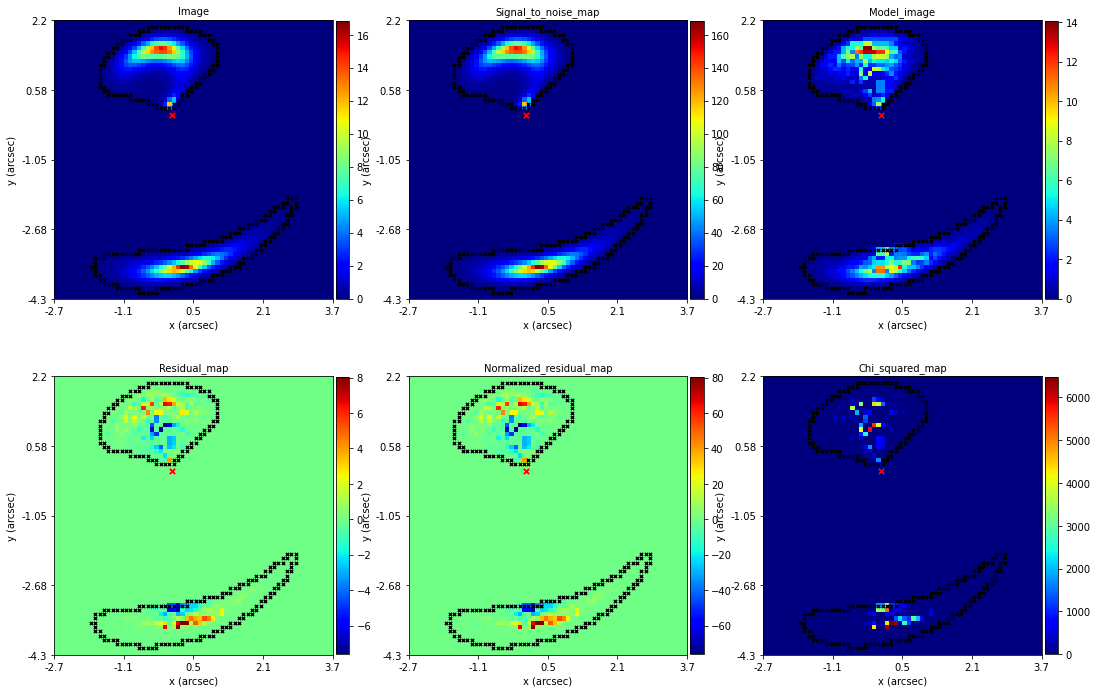

-78910.90117422128

In [30]:
plt.figure(figsize=(10,10))
log_likelihood(p0)

## Best likelihood

In [31]:
p0 = best_walker
p0

array([1.15250125e+00, 2.02610766e+00, 7.78323667e-01, 5.96364136e-03,
       3.00384949e+01])

<Figure size 720x720 with 0 Axes>

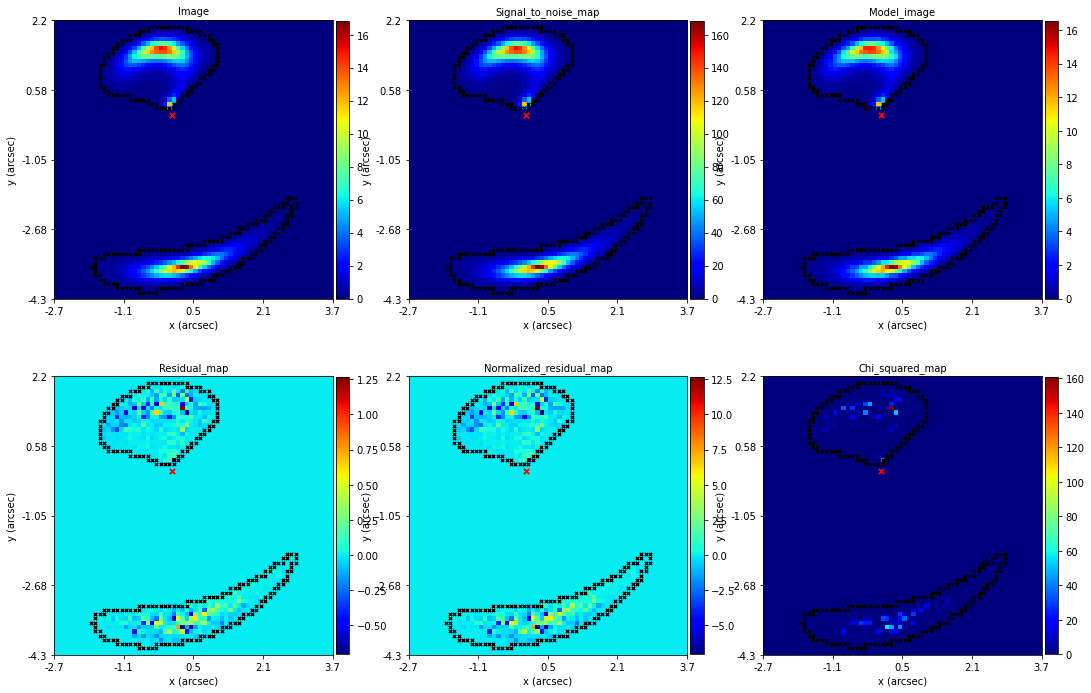

-1212.6253653601198

In [32]:
plt.figure(figsize=(10,10))
log_likelihood(p0)

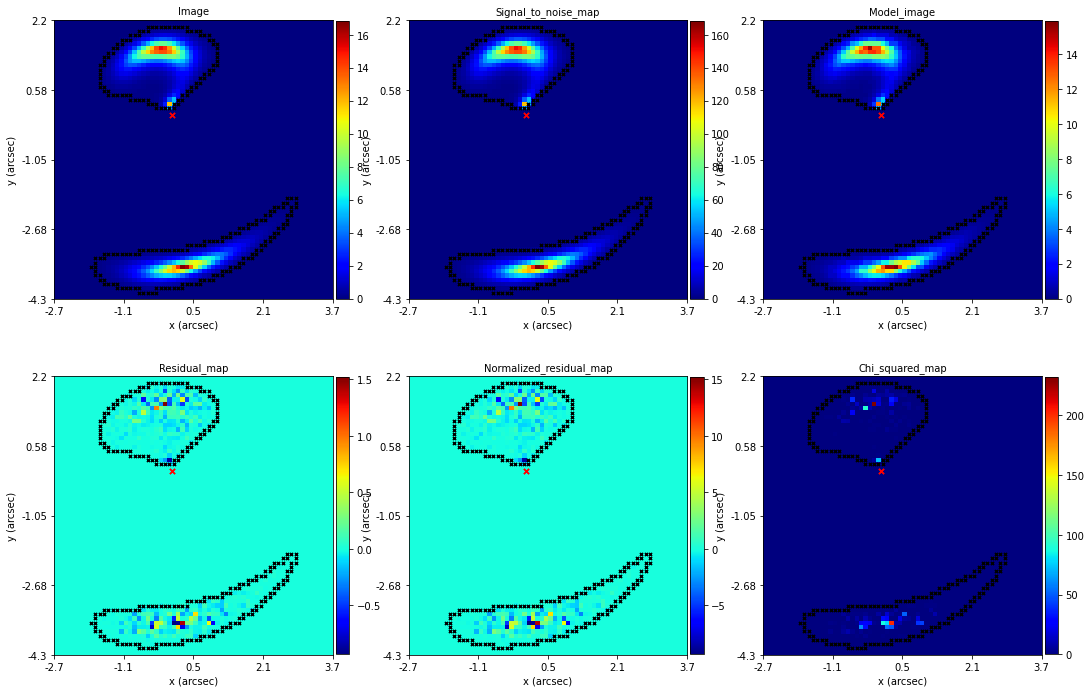

-1310.737830779055

In [33]:
# Input
p0 = np.array([1.1, 2.0, 0.85, 0.02, 88])
log_likelihood(p0)

(0.9, 1.1)

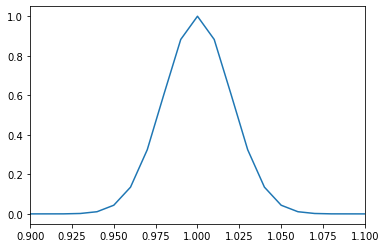

In [54]:
import matplotlib.pyplot as plt
x = np.arange(0, 2, 0.01)
exp = np.e**(-0.5 * (x - 1)**2/0.02**2)
plt.plot(x, exp)
plt.xlim(0.9, 1.1)